In [1]:
import pickle
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; sns.set_context('notebook')
from datetime import datetime
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
Characterisation_Set = pickle.load(open("Battery_Data/new_battery_cycles/Characterisation_Set.p", 'rb'))

def scale(X, torch=False):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    if torch:
        raise Exception("Not implement yet")
    else:
        X_min = X.min()
        X_max = X.max()
        
    return (X - X_min)/(X_max - X_min), X_min, X_max   

In [3]:
SoC, SoC_min, SoC_max = scale(Characterisation_Set["SoC"].T)
Current, Current_min, Current_max = scale(Characterisation_Set["Current"].T)
# Voltage, Voltage_min, Voltage_max = scale(Characterisation_Set["Voltage"].T)
Voltage = Characterisation_Set["Voltage"].T
Characterisation_Set["preprocessing"] = {
    "SoC": (SoC_max, SoC_min),
    "Current": (Current_max, Current_min)
}

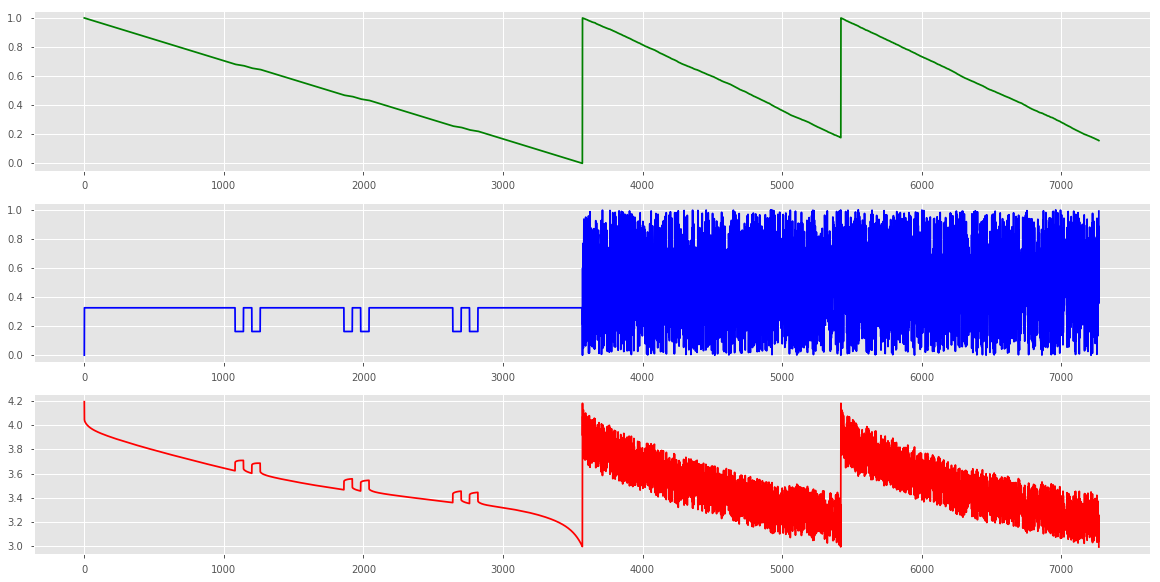

In [4]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
plt.figure("Characterisation_Set")
plt.subplot(311)
plt.plot(SoC, '-g')
plt.subplot(312)
plt.plot(Current, '-b')
plt.subplot(313)
plt.plot(Voltage, '-r')

In [5]:
class Observation(nn.Module):
    def __init__(self, layers = [1024, 512], p=0.25):
        super(Observation, self).__init__()
        self.fc1 = nn.Linear(2, layers[0])
        self.depth = len(layers)
        self.p = p
        if len(layers) >= 2:
            self.fc2 = nn.Linear(layers[0], layers[1])
        if len(layers) == 3:
            self.fc3 = nn.Linear(layers[1], layers[2])
        self.out = nn.Linear(layers[-1], 1)
                
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = F.dropout(x, training=self.training, p=self.p)
        if self.depth >= 2:
            x = torch.sigmoid(self.fc2(x))
            x = F.dropout(x, training=self.training, p=self.p)
        if self.depth == 3:
            x = torch.sigmoid(self.fc3(x))
            x = F.dropout(x, training=self.training, p=self.p)
        x = self.out(x)
        return x  

In [6]:
observation = Observation()
# init
for W in observation.parameters():
    nn.init.normal_(W)

In [7]:
# Loss and optimizer
criterion = nn.MSELoss()# Mean Squared Loss
# The weight_decay option implements L2 regularisation
optimizer = optim.Adam(observation.parameters(), weight_decay=0) 

In [8]:
# Train the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
from torch.autograd import Variable
print(device)
observation.to(device)

cuda:0


Observation(
  (fc1): Linear(in_features=2, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=1, bias=True)
)

In [11]:
def mini_batch(x, y, n_batches):
    l = int(x.shape[0] / n_batches)
    r = x.shape[0] % n_batches
    for i in range(l, l*n_batches+1, l):
        yield x[i-l:i, :], y[i-l:i, :]
    if r > 0:
        yield x[l*n_batches:x.shape[0],:], y[l*n_batches:x.shape[0],:]

In [12]:
state = np.concatenate((SoC, Current), axis=1)
state.shape

(7271, 2)

In [16]:
torch.cuda.cudaStatus

type

In [13]:
epochs = 100000
running_loss = 0.0
n_batches = 1
loss_min = 1e10

observation.eval()
for epoch in range(epochs):
    for x, y in mini_batch(state, Voltage, n_batches):
        
        x = torch.from_numpy(x)
        inputs = x.to(device, torch.float)
        y = torch.from_numpy(y)
        labels = y.to(device, torch.float)
        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = observation(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (epoch + 1) % 2000 == 0:
            print("Epoch:", epoch + 1, "Average Loss:", running_loss / 2000, "Current loss:", loss.item())
            running_loss = 0.0
    if loss.item() < loss_min:
        loss_min = loss.item()
        torch.save(observation.state_dict(), "./Battery_Data/new_battery_cycles/Observation_v2.mdl")

Epoch: 2000 Average Loss: 0.029667141421377892 Current loss: 0.00035641470458358526


KeyboardInterrupt: 

In [13]:
observation = Observation()
observation.load_state_dict(torch.load("./Battery_Data/new_battery_cycles/Observation_v2.mdl"))
observation.to(device)
observation.eval()
with torch.no_grad():
    x = torch.from_numpy(state)
    inputs = x.to(device, torch.float)
    results = observation(inputs)
    y = results.to("cpu").numpy()

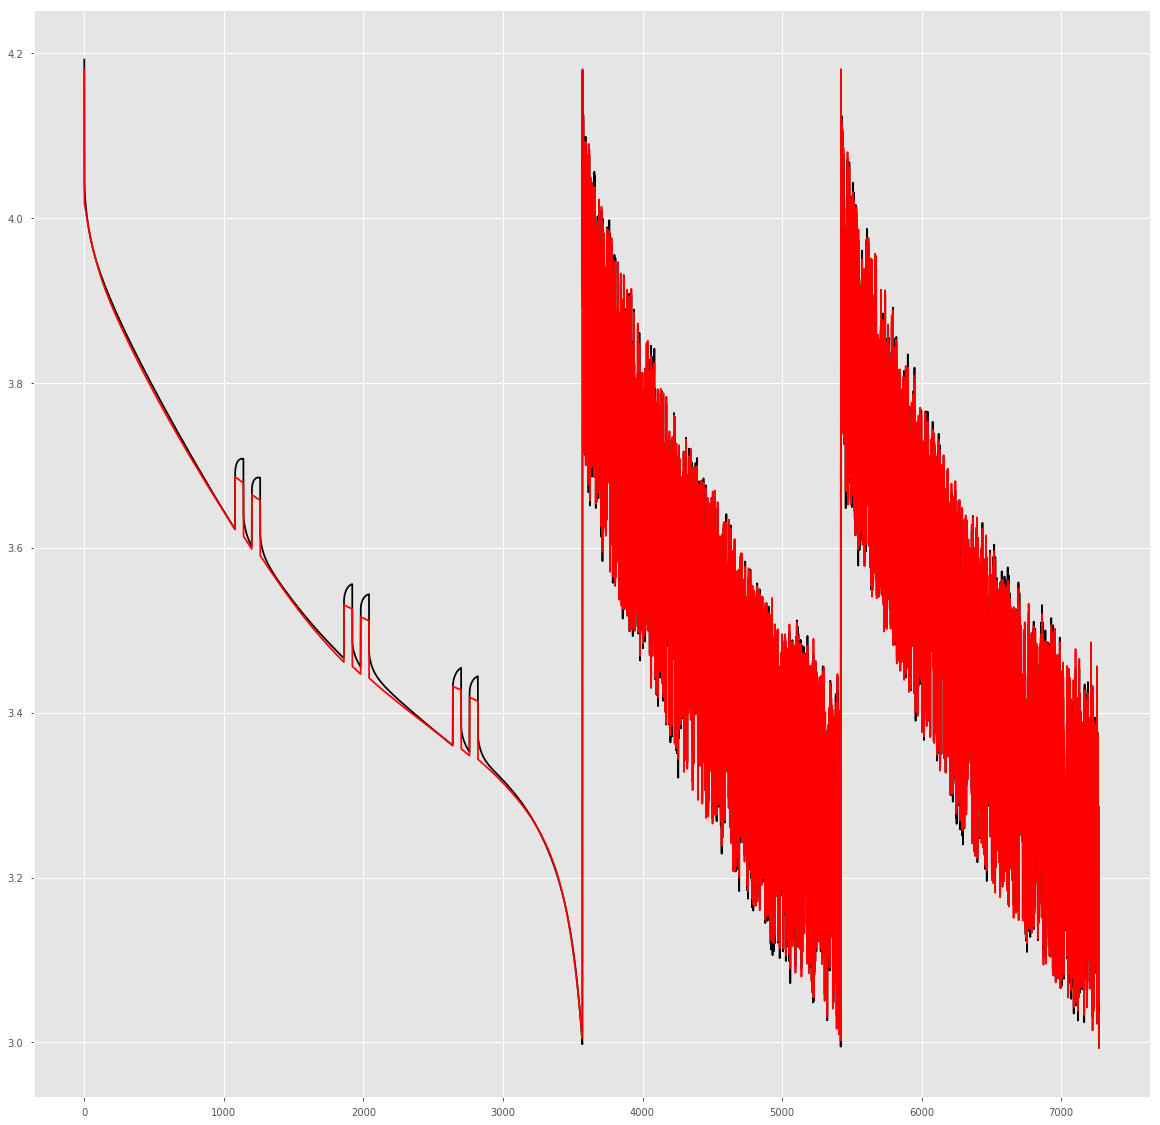

In [14]:
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
plt.figure("Trained vs Real")
plt.plot(Voltage, '-k')
plt.plot(y, '-r')

In [15]:
# Characterisation_Set["preprocessing"]["layers"] = [1024, 512]
# Characterisation_Set["preprocessing"]["dropout"] = 0.0
# Characterisation_Set["preprocessing"]["weight_decay"] = 0.0
# Characterisation_Set["preprocessing"]["epochs"] = 100000
# Characterisation_Set["preprocessing"]["optimizer"] = "Adam"
# Characterisation_Set["preprocessing"]["lr"] = 0.001,
# Characterisation_Set["preprocessing"]["betas"] = (0.9, 0.999),
# Characterisation_Set["preprocessing"]["eps"] = 1e-08
# pickle.dump(Characterisation_Set, open("Battery_Data/new_battery_cycles/Characterisation_Set.p", 'wb'))